In [1]:
import spacy
import pandas as pd
import re
import jsonlines
from utils.prepare_rules import create_rules 
from utils.prepare_data import create_prepare_file
from utils.expand_model import expand_model
from tqdm import tqdm
import os.path
from spacy.language import Language
from spacy import displacy
import matplotlib.pyplot as plt

In [2]:
DATA='data/pledges - pledges.csv'
BRANDS='data/brands.jsonl'
RULES='data/rules.jsonl'
DATA_PREPARE='data/pledges_prepare.csv'

BRAND_PATH = 'data/brands/'
RULES_PATH = 'data/rules/'

#### Загружаем данные для парсинга и данные по брендам

In [3]:
data = pd.read_csv(DATA, delimiter='|')

In [4]:
brands = list(jsonlines.open(BRANDS))
list_brands = [x['id'] for x in brands]

### Генерируем правила для моделей и марок и сохраняем их в файлы

In [5]:
rules = create_rules(brands)

# save in file
with jsonlines.open(RULES, mode='w') as writer:
    writer.write_all(rules)
    
for brand in list_brands:
    rules_model = create_rules(brands)
    try:
        models = jsonlines.open(BRAND_PATH + brand +'.jsonl')
        rules_model = create_rules(models, label='MODEL', prefix=brand+'_')
        with jsonlines.open(RULES_PATH + brand + '_rules.jsonl', mode='w') as writer:
            writer.write_all(rules_model)
    except:
        pass
#         print('Для бренда '+ brand+ ' не найден файл с моделями ' + BRAND_PATH + brand +'.jsonl')

### Попытаемся отбить пробелы
Возможно это не слишком хорошая идея...

In [6]:
list_models = []
for brand in list_brands:
    try:
        reader = jsonlines.open('data/brands/'+ brand +'.jsonl')
        list_models = list_models + list(reader)
    except:
        pass

In [7]:
str_with_space = create_prepare_file(data=data['vehicleproperty_description_short'].values, brands=brands+list_models)

data['with_space'] = str_with_space
data.to_csv(DATA_PREPARE, index=False)

In [8]:
data = pd.read_csv(DATA_PREPARE, delimiter=',')

### NER

In [9]:
rules = list(jsonlines.open(RULES))
for brand in list_brands:
    if os.path.exists(RULES_PATH + brand + '_rules.jsonl'):
            file = jsonlines.open(RULES_PATH + brand + '_rules.jsonl')
            rules = rules + (list(file))

In [10]:
colors = {"BRAND": "#aa9cfc", "MODEL": "#fc9ce7"}
options = {"ents": ["BRAND", "MODEL"], "colors": colors}

nlp = spacy.load("ru_core_news_sm",exclude=['tok2vec', 'morphologizer', 'parser', 'senter', 'attribute_ruler', 'lemmatizer'])

config = { "overwrite_ents": True }
ruler = nlp.add_pipe("entity_ruler", before="ner", config=config) #.from_disk(RULES_PATH +"all_rules.jsonl", )
ruler.add_patterns(rules)

nlp.add_pipe("expand_model", after="ner")

ents_info = []
html=[]
for article in tqdm(data['with_space']):
    article = str(article)
    doc = nlp(article)
    ents_info.append(doc.user_data)
    html.append(doc if len(doc.ents) == 0 else displacy.render(doc, style="ent", jupyter=False, options=options))
    


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.28it/s]


In [11]:
ents_info_df = pd.DataFrame.from_records(ents_info)
data.index.name = 'order'
data = data.join(ents_info_df,on='order')
data = data.assign(HTML = html)

In [12]:
doc = nlp('Грузовой бортовой ВИС 234600-40( ВАЗ 21214)2013 годавыпуска№ кузова (№ шасси) X6D234600D0005484№ двигателя 9989318ПТС № 63 НС 503537 от 09.04.2012 г.')
for token in doc:
    print(token.text)
doc.ents

Грузовой
бортовой
ВИС
234600
-
40
(
ВАЗ
21214)2013
годавыпуска
№
кузова
(
№
шасси
)
X6D234600D0005484
№
двигателя
9989318ПТС
№
63
НС
503537
от
09.04.2012
г
.


(ВАЗ,)

In [13]:
brand = 'lada'
data.index.name= 'id'

df = data[data['first_brand']==brand][['HTML', 'brands', 'models', 'have_fit_model', 'count_brands','count_models']]
df = df[df['have_fit_model'] == False]
print(df.shape[0])
df = df[0:400]

42


In [22]:
def left_align(s):
    direction = 'left'
    return 'text-align: %s' % direction

df.style.applymap(left_align, subset=pd.IndexSlice[:, ['HTML']])

,HTML,brands,models,have_fit_model,count_brands,count_models
id,,,,,,
26,автомобиль марки ВАЗ BRAND 21093легковые прочиегод выпуска 2001 государственный регистрационный знак - У181ХО18идентификационный номер (VIN) ХТА21093023141367модель № двигателя 21113268606шасси № ---кузов № 3141367цвет серебристо - зеленый,lada,,False,1,0
213,LADA BRAND SAMARA2011г/в.цвет: темно-вишневый.г/н: О 820 ОВ 174. ПТС 63 НК 919034 от 27.10.2011г.,lada,,False,1,0
214,LADA BRAND SAMARA2011г/в.цвет: сине-черный.г/н: Р 128 ОВ 174. ПТС 63 НК 958534 от 24.11.2011г.,lada,,False,1,0
215,LADA BRAND SAMARA2011г/в.цвет: светло-серебристый.г/н: Р 961 ОВ 174. ПТС 63 НК 968395 от 02.12.2011г.,lada,,False,1,0
216,LADA BRAND SAMARA2011г/в.цвет: сине-черныйг/н: Р 962 ОВ 174. ПТС 63 НК 970932 от 06.12.2011г.,lada,,False,1,0
217,LADA BRAND SAMARA2011г/в.цвет: сине-черныйг/н: С 384 ОВ 174. ПТС 63 НМ 008644 от 08.12.2011г,lada,,False,1,0
218,LADA BRAND SAMARA2011г/в.цвет: сине-черныйг/н: С 382 ОВ 174. ПТС 63 НМ 008643 от 08.12.2011г.,lada,,False,1,0
1069,ВАЗ BRAND 232900-010-412005,lada,,False,1,0
1189,Автомобиль ВАЗ BRAND 21310 гос. № Н307НР 68,lada,,False,1,0


In [29]:
data[data['count_models']!=0][data['have_fit_model'] == False].shape[0]

/tmp/ipykernel_426689/1050499724.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['count_models']!=0][data['have_fit_model'] == False].shape[0]


685

/tmp/ipykernel_426689/3268720163.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['count_models']!=0][data['have_fit_model'] == False].shape[0],


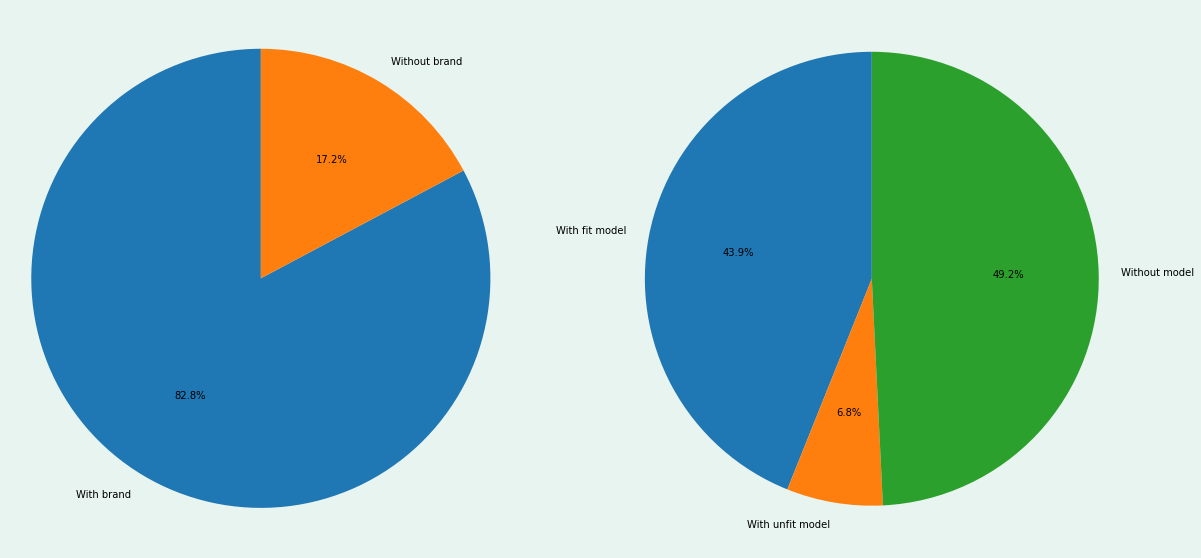

In [28]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='#e8f4f0')

labels = 'With brand', 'Without brand'
sizes = [data.count()['first_brand'], data.shape[0] - data.count()['first_brand']]
ax = axes[0]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

labels = 'With fit model', 'With unfit model', 'Without model'
sizes = [data[
    data['have_fit_model']].shape[0], 
         data[data['count_models']!=0][data['have_fit_model'] == False].shape[0], 
         data[data['count_models']==0].shape[0]]
ax = axes[1]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [30]:
df1 = pd.DataFrame(data['first_brand'].value_counts())
df1.index.name = 'brand'

df2 = data.groupby(['first_brand']).sum()
df2.index.name = 'brand'

df = df1.join(df2,on='brand')

df = df[['count_brands', 'count_models','have_fit_model']][:40]
df

,count_brands,count_models,have_fit_model
brand,,,
lada,772,831,725
mercedes-benz,604,213,42
toyota,454,446,439
kia,437,432,430
hyundai,398,323,315
kamaz,335,143,124
ford,305,308,303
volkswagen,285,266,266
nissan,257,223,210


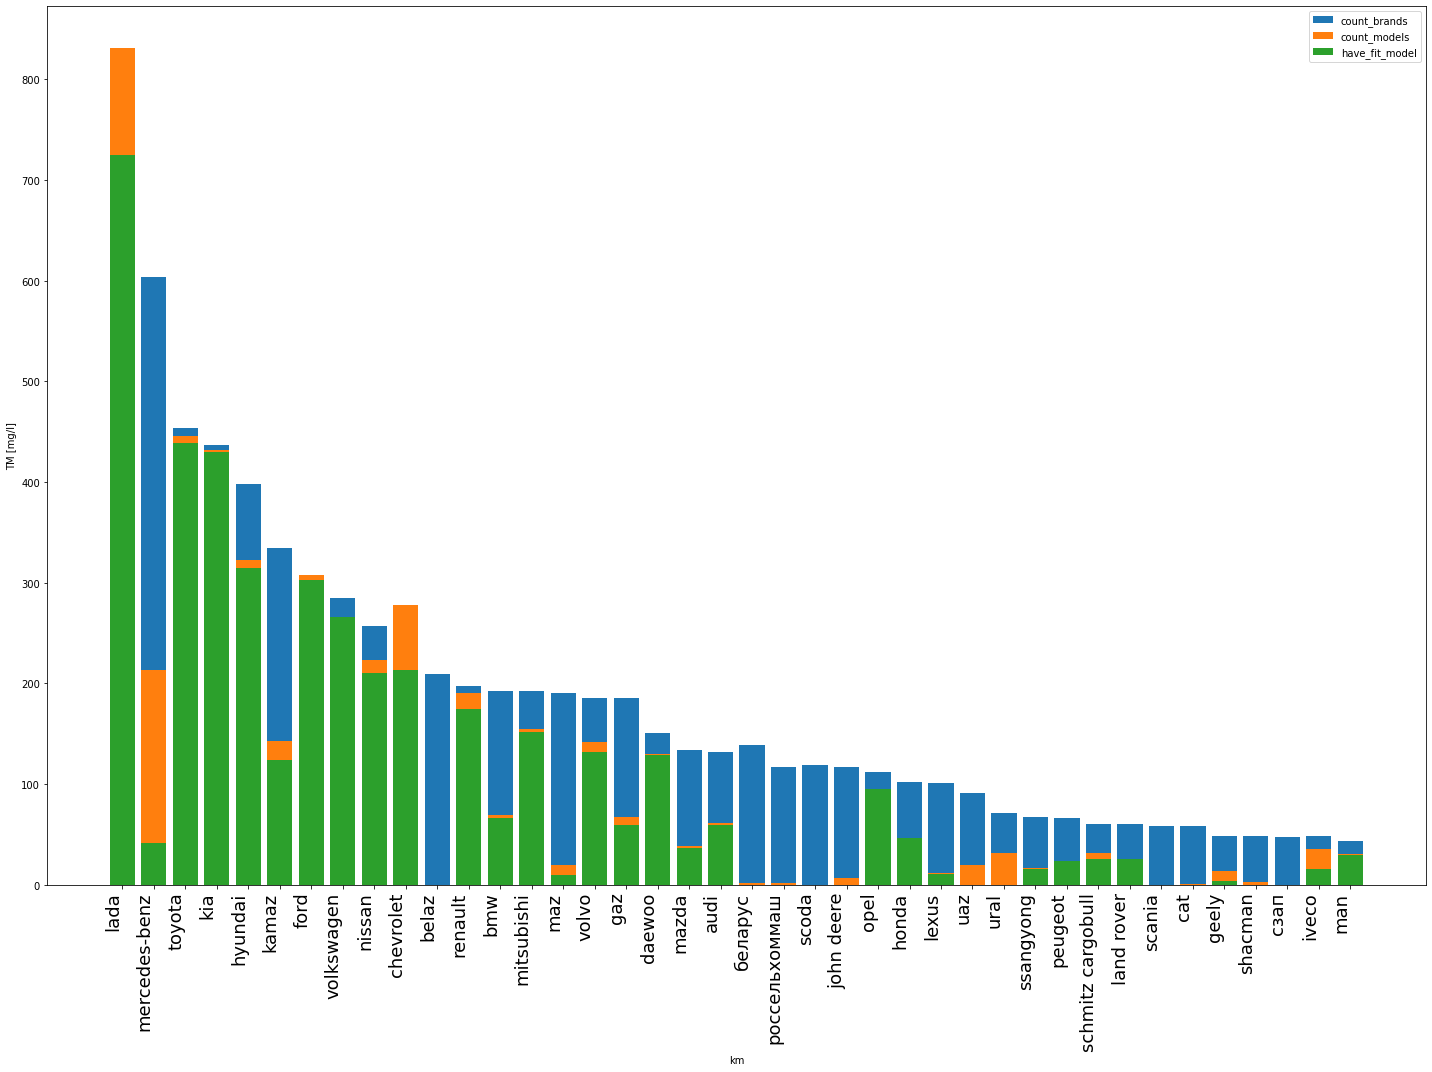

In [27]:
width = 15
bottom = 0

for i in df.columns:
    plt.bar(df.index, df[i])#, width=width) #, bottom=bottom)
    bottom += df[i]

plt.rcParams["figure.figsize"] = (20,15)
plt.xticks(fontsize=18,rotation=90, ha='right')
plt.ylabel('TM [mg/l]')
plt.xlabel('km')
plt.legend(df.columns)
plt.tight_layout()

In [21]:
re.sub(r'(^[0-9])(год|гос)', r' \1\2 ', "-4122год")

'-4122год'